<a href="https://colab.research.google.com/github/tsai-praveen/tsai-assignments/blob/main/s5/S5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = "cuda" if torch.cuda.is_available() else "cpu"

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [9]:
from model import Net, NormType

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [110]:
# Keep this separate 

train_losses = dict()
test_losses = dict()
train_acc = dict()
test_acc = dict()

def blank_out(norm_type: NormType = None):
    for x in NormType:
        ntype = str(x.value)
        if norm_type and ntype != norm_type.value:
            continue

        train_losses[ntype] = []
        test_losses[ntype] = []
        train_acc[ntype] = []
        test_acc[ntype] = []

In [111]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, norm_type, l1_reg=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
#   train_losses[norm_type.value] = []
#   train_acc[norm_type.value] = []
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_rate = 0.0005
    if l1_reg:
        for x in model.parameters():
            loss += l1_rate * torch.norm(x, p=1)

    train_losses[norm_type.value].append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[norm_type.value].append(100*correct/processed)

def test(model, device, test_loader, norm_type):
    model.eval()
    test_loss = 0
    correct = 0
    # test_losses[norm_type.value] = []
    # test_acc[norm_type.value] = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[norm_type.value].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[norm_type.value].append(100. * correct / len(test_loader.dataset))

### Display Wrong classifications

In [112]:
# import necessary libraries
import matplotlib.pyplot as plt

# define a function to show wrongly classified images
def wrong_classifications(model, test_loader):

    wrongly_classified_images = []
    actual_labels = []
    predicted_labels = []

    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    wrongly_classified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(wrongly_classified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


# Group Normalization
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [113]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)

curr_normtype = NormType.GROUPNORM
model = Net(norm_type=curr_normtype).to(device)
print(summary(model, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─GroupNorm: 2-3                    [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─GroupNorm: 2-7                    [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxPool2d

In [114]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, curr_normtype)
    scheduler.step()
    test(model, device, test_loader, curr_normtype)

EPOCH: 1


Loss=0.19704528152942657 Batch_id=468 Accuracy=80.72: 100%|██████████| 469/469 [00:07<00:00, 64.89it/s] 



Test set: Average loss: 0.1669, Accuracy: 9667/10000 (96.67%)

EPOCH: 2


Loss=0.17979080975055695 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:07<00:00, 64.14it/s] 



Test set: Average loss: 0.1391, Accuracy: 9733/10000 (97.33%)

EPOCH: 3


Loss=0.19720375537872314 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:07<00:00, 63.00it/s]



Test set: Average loss: 0.1351, Accuracy: 9736/10000 (97.36%)

EPOCH: 4


Loss=0.16010130941867828 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:07<00:00, 63.42it/s] 



Test set: Average loss: 0.1356, Accuracy: 9733/10000 (97.33%)

EPOCH: 5


Loss=0.12672120332717896 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:07<00:00, 65.14it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 6


Loss=0.14583908021450043 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:07<00:00, 64.84it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 7


Loss=0.23629866540431976 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:07<00:00, 66.32it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 8


Loss=0.1747446060180664 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:07<00:00, 65.43it/s]  



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 9


Loss=0.1747378557920456 Batch_id=468 Accuracy=96.10: 100%|██████████| 469/469 [00:07<00:00, 65.01it/s]  



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 10


Loss=0.20851820707321167 Batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:07<00:00, 64.94it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 11


Loss=0.20435571670532227 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:07<00:00, 65.53it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 12


Loss=0.1163857951760292 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:07<00:00, 66.44it/s]  



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 13


Loss=0.17787015438079834 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:06<00:00, 68.18it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 14


Loss=0.13424788415431976 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:07<00:00, 65.04it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 15


Loss=0.27046483755111694 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:07<00:00, 65.63it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 16


Loss=0.11849584430456161 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:06<00:00, 68.18it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 17


Loss=0.15373621881008148 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:06<00:00, 68.38it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 18


Loss=0.17399996519088745 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:07<00:00, 64.88it/s]



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 19


Loss=0.20145809650421143 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:07<00:00, 64.66it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)

EPOCH: 20


Loss=0.20215772092342377 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:07<00:00, 63.92it/s] 



Test set: Average loss: 0.1355, Accuracy: 9732/10000 (97.32%)



### Wrong classifications

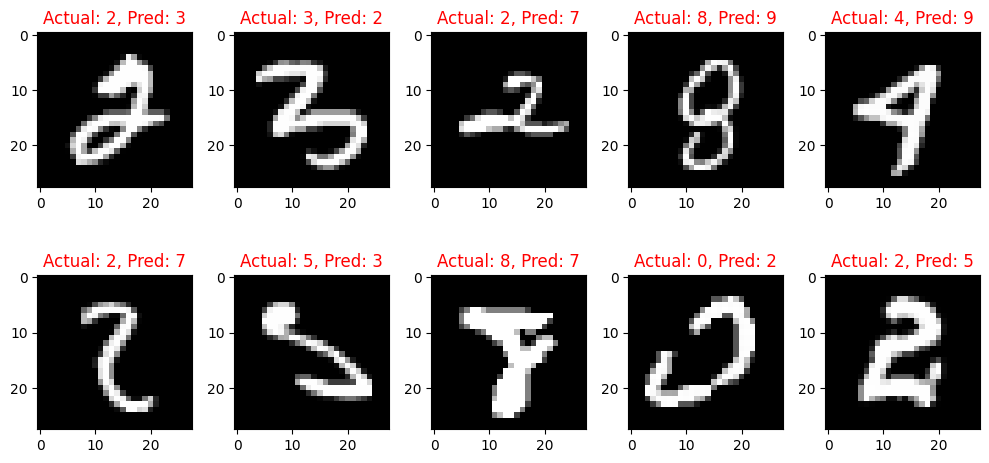

In [115]:
wrong_classifications(model, test_loader)

# Layer Normalization

In [116]:
curr_normtype = NormType.LAYERNORM
model_ln = Net(norm_type=curr_normtype).to(device)
print(summary(model_ln, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─LayerNorm: 2-3                    [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─LayerNorm: 2-7                    [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxPool2d

In [117]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

# EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model_ln, device, train_loader, optimizer, epoch, curr_normtype)
    scheduler.step()
    test(model_ln, device, test_loader, curr_normtype)

EPOCH: 1


Loss=0.21040119230747223 Batch_id=468 Accuracy=82.85: 100%|██████████| 469/469 [00:07<00:00, 63.59it/s] 



Test set: Average loss: 0.1526, Accuracy: 9708/10000 (97.08%)

EPOCH: 2


Loss=0.19150786101818085 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:07<00:00, 65.84it/s] 



Test set: Average loss: 0.1177, Accuracy: 9757/10000 (97.57%)

EPOCH: 3


Loss=0.14247165620326996 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:07<00:00, 66.19it/s] 



Test set: Average loss: 0.1125, Accuracy: 9777/10000 (97.77%)

EPOCH: 4


Loss=0.22846591472625732 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:07<00:00, 66.14it/s] 



Test set: Average loss: 0.1123, Accuracy: 9778/10000 (97.78%)

EPOCH: 5


Loss=0.15930183231830597 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:07<00:00, 63.41it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 6


Loss=0.18882595002651215 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:07<00:00, 65.19it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 7


Loss=0.16468702256679535 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:07<00:00, 64.03it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 8


Loss=0.18109874427318573 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:07<00:00, 66.00it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 9


Loss=0.10706426948308945 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:07<00:00, 66.95it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 10


Loss=0.17732267081737518 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:07<00:00, 61.10it/s]



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 11


Loss=0.20648346841335297 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:07<00:00, 61.37it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 12


Loss=0.10733669251203537 Batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:07<00:00, 64.14it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 13


Loss=0.18074508011341095 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:07<00:00, 66.80it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 14


Loss=0.1145656630396843 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:07<00:00, 61.76it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 15


Loss=0.13738897442817688 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:07<00:00, 66.05it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 16


Loss=0.24549444019794464 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:07<00:00, 61.08it/s]



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 17


Loss=0.09265575557947159 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:07<00:00, 59.53it/s]



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 18


Loss=0.21793992817401886 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:07<00:00, 59.24it/s]



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 19


Loss=0.14870424568653107 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:07<00:00, 66.61it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)

EPOCH: 20


Loss=0.25258830189704895 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:07<00:00, 65.80it/s] 



Test set: Average loss: 0.1122, Accuracy: 9778/10000 (97.78%)



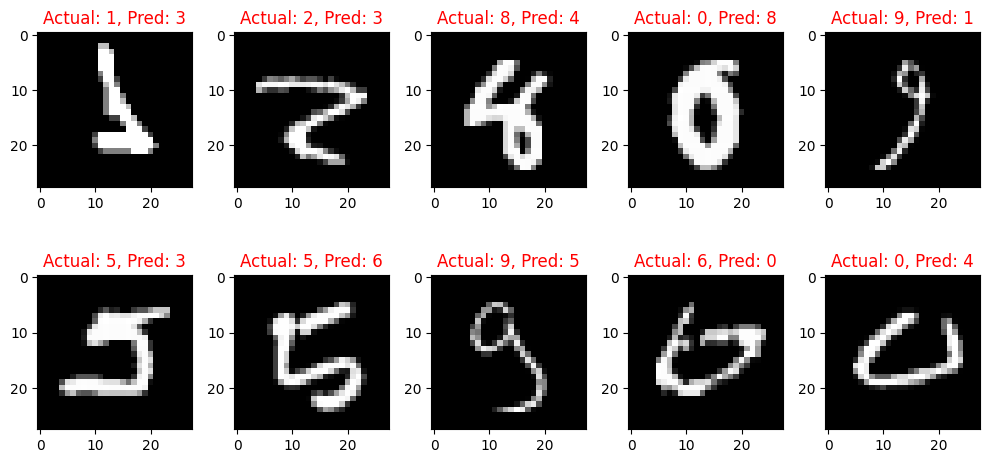

In [118]:
wrong_classifications(model_ln, test_loader)

# Batch Normalization + L1 Regularization

In [119]:
curr_normtype = NormType.BATCHNORM
model_bn = Net(norm_type=curr_normtype).to(device)
print(summary(model_bn, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 26, 26]            --
│    └─Conv2d: 2-1                       [1, 8, 26, 26]            72
│    └─ReLU: 2-2                         [1, 8, 26, 26]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 26, 26]            --
│    └─Dropout: 2-4                      [1, 8, 26, 26]            --
├─Sequential: 1-2                        [1, 32, 24, 24]           --
│    └─Conv2d: 2-5                       [1, 32, 24, 24]           2,304
│    └─ReLU: 2-6                         [1, 32, 24, 24]           --
│    └─BatchNorm2d: 2-7                  [1, 32, 24, 24]           --
│    └─Dropout: 2-8                      [1, 32, 24, 24]           --
├─Sequential: 1-3                        [1, 10, 24, 24]           --
│    └─Conv2d: 2-9                       [1, 10, 24, 24]           320
├─MaxPool2d

In [120]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

# EPOCHS = 2
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model_bn, device, train_loader, optimizer, epoch, curr_normtype, True)
    scheduler.step()
    test(model_bn, device, test_loader, curr_normtype)

EPOCH: 1


Loss=0.33492404222488403 Batch_id=468 Accuracy=83.18: 100%|██████████| 469/469 [00:07<00:00, 64.66it/s] 



Test set: Average loss: 0.1179, Accuracy: 9785/10000 (97.85%)

EPOCH: 2


Loss=0.34969210624694824 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:07<00:00, 64.75it/s] 



Test set: Average loss: 0.1030, Accuracy: 9803/10000 (98.03%)

EPOCH: 3


Loss=0.28618088364601135 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:07<00:00, 64.94it/s] 



Test set: Average loss: 0.0978, Accuracy: 9816/10000 (98.16%)

EPOCH: 4


Loss=0.3014860153198242 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:06<00:00, 67.07it/s]  



Test set: Average loss: 0.0959, Accuracy: 9827/10000 (98.27%)

EPOCH: 5


Loss=0.35053765773773193 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:07<00:00, 66.42it/s] 



Test set: Average loss: 0.0980, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Loss=0.34146857261657715 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:06<00:00, 67.22it/s] 



Test set: Average loss: 0.0980, Accuracy: 9817/10000 (98.17%)

EPOCH: 7


Loss=0.27507930994033813 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:07<00:00, 66.31it/s] 



Test set: Average loss: 0.0984, Accuracy: 9817/10000 (98.17%)

EPOCH: 8


Loss=0.38245439529418945 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:07<00:00, 65.91it/s] 



Test set: Average loss: 0.0982, Accuracy: 9821/10000 (98.21%)

EPOCH: 9


Loss=0.32667189836502075 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:07<00:00, 66.88it/s] 



Test set: Average loss: 0.0989, Accuracy: 9810/10000 (98.10%)

EPOCH: 10


Loss=0.3389432728290558 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:07<00:00, 62.10it/s] 



Test set: Average loss: 0.0981, Accuracy: 9819/10000 (98.19%)

EPOCH: 11


Loss=0.39751380681991577 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:07<00:00, 59.53it/s]



Test set: Average loss: 0.1000, Accuracy: 9811/10000 (98.11%)

EPOCH: 12


Loss=0.39651066064834595 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:07<00:00, 61.54it/s]



Test set: Average loss: 0.0979, Accuracy: 9816/10000 (98.16%)

EPOCH: 13


Loss=0.3572244942188263 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:07<00:00, 62.75it/s] 



Test set: Average loss: 0.0960, Accuracy: 9821/10000 (98.21%)

EPOCH: 14


Loss=0.3207170069217682 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:07<00:00, 61.28it/s] 



Test set: Average loss: 0.0978, Accuracy: 9815/10000 (98.15%)

EPOCH: 15


Loss=0.32853177189826965 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:08<00:00, 56.95it/s]



Test set: Average loss: 0.0993, Accuracy: 9814/10000 (98.14%)

EPOCH: 16


Loss=0.33848774433135986 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:08<00:00, 57.77it/s]



Test set: Average loss: 0.0972, Accuracy: 9816/10000 (98.16%)

EPOCH: 17


Loss=0.29941871762275696 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:08<00:00, 58.26it/s]



Test set: Average loss: 0.0971, Accuracy: 9821/10000 (98.21%)

EPOCH: 18


Loss=0.3490138649940491 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:08<00:00, 58.59it/s] 



Test set: Average loss: 0.0975, Accuracy: 9817/10000 (98.17%)

EPOCH: 19


Loss=0.3281984329223633 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:07<00:00, 62.69it/s] 



Test set: Average loss: 0.0969, Accuracy: 9818/10000 (98.18%)

EPOCH: 20


Loss=0.29161253571510315 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:08<00:00, 56.11it/s]



Test set: Average loss: 0.0991, Accuracy: 9809/10000 (98.09%)



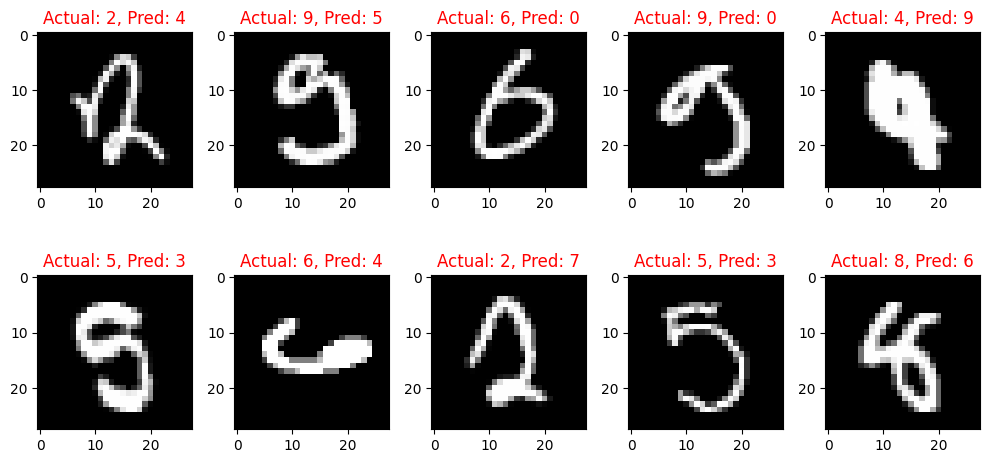

In [121]:
wrong_classifications(model_bn, test_loader)

# Plot our losses

In [122]:
len(train_losses['GN']), len(train_losses['LN']), len(train_losses['BN'])

(9380, 9380, 9380)

In [123]:
tr_losses = dict()
tr_losses["GN"] = [x.cpu().item() for x in train_losses["GN"]]
tr_losses["LN"] = [x.cpu().item() for x in train_losses["LN"]]
tr_losses["BN"] = [x.cpu().item() for x in train_losses["BN"]]
print(tr_losses.keys())

dict_keys(['GN', 'LN', 'BN'])


In [124]:
print(test_acc['GN'], test_acc['LN'], test_acc['BN'])
print(test_losses['GN'], test_losses['LN'], test_losses['BN'])

[96.67, 97.33, 97.36, 97.33, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32, 97.32] [97.08, 97.57, 97.77, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78, 97.78] [97.85, 98.03, 98.16, 98.27, 98.16, 98.17, 98.17, 98.21, 98.1, 98.19, 98.11, 98.16, 98.21, 98.15, 98.14, 98.16, 98.21, 98.17, 98.18, 98.09]
[0.16690264010429381, 0.13905666120052337, 0.13507154195308685, 0.1355951653599739, 0.13553026804924012, 0.1355339350938797, 0.1355339412212372, 0.13553394130468369, 0.13553393963575364, 0.13553394265174865, 0.13553394061326982, 0.13553394269943236, 0.13553393974304198, 0.13553394198417665, 0.13553394291400908, 0.13553394026756285, 0.13553394074440003, 0.1355339424610138, 0.13553393974304198, 0.1355339404940605] [0.15258925564289094, 0.1177310518026352, 0.11245038242340089, 0.11226766057014466, 0.11223186079263688, 0.11222947525978089, 0.11222935391664506, 0.1122293551802

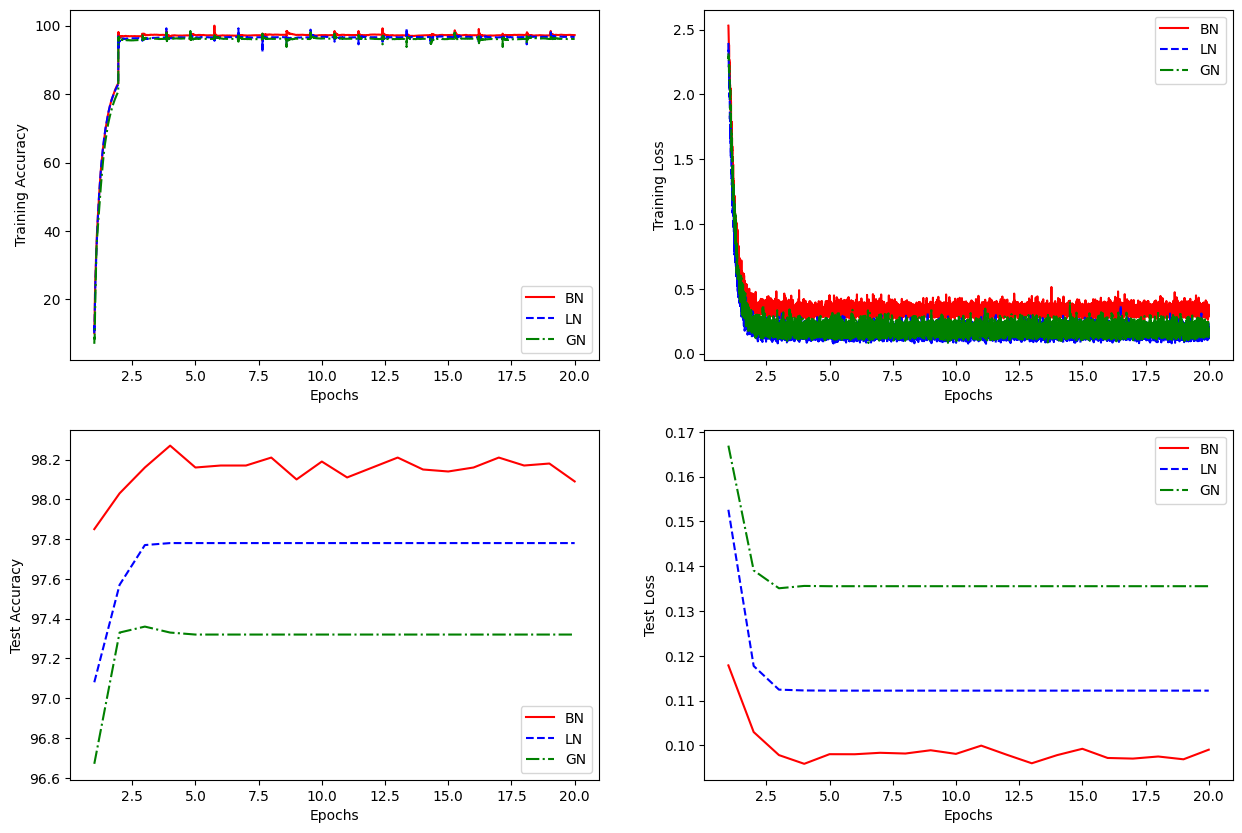

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2,2,figsize=(15,10))
plot_meta = {
                "BN":{"color":"red", "pattern": "-"},
                "LN":{"color":"blue", "pattern": "--"},
                "GN":{"color":"green", "pattern": "-."}
            }

def set_plot_details(graph, ylabel):
    graph.set_xlabel('Epochs')
    graph.set_ylabel(ylabel)
    graph.tick_params(axis='y')
    graph.legend(plot_meta.keys())

for norm_type in NormType:
    ntype = str(norm_type.value)
    color, pattern = plot_meta[ntype].values()
    train_epoch_adjusted = np.linspace(1, EPOCHS, len(train_losses[ntype]))
    test_epoch_adjusted = np.linspace(1, EPOCHS, len(test_losses[ntype]))
    axs[0, 0].plot(train_epoch_adjusted, train_acc[ntype], color=color, linestyle=pattern, label=ntype)
    axs[0, 1].plot(train_epoch_adjusted, tr_losses[ntype], color=color, linestyle=pattern, label=ntype)
    axs[1, 0].plot(test_epoch_adjusted, test_acc[ntype], color=color, linestyle=pattern, label=ntype)
    axs[1, 1].plot(test_epoch_adjusted, test_losses[ntype], color=color, linestyle=pattern, label=ntype)


# axs[0, 0].set_title("Training Accuracy")
set_plot_details(axs[0, 0], "Training Accuracy")
set_plot_details(axs[0, 1], "Training Loss")
set_plot_details(axs[1, 0], "Test Accuracy")
set_plot_details(axs[1, 1], "Test Loss")

# fig.tight_layout()
plt.show()